In [10]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

In [16]:
def adjust_data(df, window):

    df['length'] = df['length'].astype(int)
    df['time'] = df['time'].astype(float)
    df['ip_dst'] = df['ip_dst'].astype(str)
    df['ip_src'] = df['ip_src'].astype(str)
    df['protocol'] = df['protocol'].astype(str)
    
    df['time_interval'] = (df['time'] // window)
    
    grouped = df.groupby('time_interval')
    
    # Creating the new dataframe with the specified features
    
    new_df = grouped['length'].agg(
        avg_length='mean',
        var_length='var',
        min_length='min',
        max_length='max',
        count_rows='size'
    )
    
    new_df
    # Calculating unique counts for ip_src, ip_dst, and their pairs
    
    new_df['unique_ip_src'] = grouped['ip_src'].nunique()
    
    new_df['unique_ip_dst'] = grouped['ip_dst'].nunique()
    
    new_df['unique_ip_src_dst'] = grouped.apply(lambda x: len(x[['ip_src', 'ip_dst']].drop_duplicates()))
    
     
    # Calculating ratios
    
    new_df['rows_per_unique_ip_src'] = new_df['count_rows'] / new_df['unique_ip_src']
    
    new_df['rows_per_unique_ip_dst'] = new_df['count_rows'] / new_df['unique_ip_dst']
    
    new_df['rows_per_unique_ip_src_dst'] = new_df['count_rows'] / new_df['unique_ip_src_dst']
    
    
    # Function to calculate entropy
    def calculate_entropy(series):
        value_counts = series.value_counts()
        probabilities = value_counts / len(series)
        return entropy(probabilities)
    
    # Adding entropy calculations for source and destination IPs
    new_df['entropy_ip_src'] = grouped['ip_src'].apply(calculate_entropy)
    new_df['entropy_ip_dst'] = grouped['ip_dst'].apply(calculate_entropy)
    
    new_df['repeated_connections'] = grouped.apply(lambda x: x.duplicated(subset=['ip_src', 'ip_dst']).sum())
    
    
    # Handling division by zero
    
    new_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    new_df.fillna(0, inplace=True)
    
    
     
    
    # Calculating the percentage of each protocol in each interval
    
    # protocols = df['protocol'].unique()
    
    # for protocol in protocols:
    
    #     protocol_column = f'percent_{protocol}'
    
    #     new_df[protocol_column] = grouped.apply(lambda x: (x['protocol'] == protocol).sum() / x.shape[0])
    
     
    
    new_df.reset_index(inplace=True)
    return new_df

In [29]:
ddos = pd.read_csv('CommandInjection.csv')
ddos.set_index('Unnamed: 0', inplace=True)
ddos

,time,ip_dst,ip_src,length,protocol
Unnamed: 0,,,,,
1,0.000000,192.168.137.163,47.254.83.84,74,TCP
2,0.088743,192.168.137.163,47.254.83.84,66,TCP
3,0.089114,192.168.137.163,47.254.83.84,66,TCP
4,0.119246,192.168.137.163,47.254.83.84,60,UDP
6,0.385753,192.168.137.219,47.88.56.147,60,TCP
...,...,...,...,...,...
55043,2339.894180,192.168.137.1,192.168.137.163,98,ICMP
55044,2340.014434,255.255.255.255,192.168.137.123,214,UDP
55045,2340.065338,192.168.137.1,192.168.137.242,110,ICMP


In [30]:
benign = pd.read_csv("BenignTraffic.csv")
benign.set_index('Unnamed: 0', inplace=True)
benign

,time,ip_dst,ip_src,length,protocol
Unnamed: 0,,,,,
0,0.000000,99.81.244.93,192.168.137.175,2962,TCP
1,0.000164,99.81.244.93,192.168.137.175,2962,TCP
2,0.000269,99.81.244.93,192.168.137.175,1514,TCP
3,0.000414,99.81.244.93,192.168.137.175,1514,TCP
4,0.001800,99.81.244.93,192.168.137.175,1514,TCP
...,...,...,...,...,...
3644531,33327.964738,255.255.255.255,192.168.137.82,214,UDP
3644532,33327.967599,192.168.137.253,23.78.206.51,2962,TCP
3644533,33327.967997,192.168.137.253,23.78.206.51,4410,TCP


In [31]:
ddos_adjusted = adjust_data(ddos, 5)
ddos_adjusted['DDOS'] = 1
ddos_adjusted

,time_interval,avg_length,var_length,min_length,max_length,count_rows,unique_ip_src,unique_ip_dst,unique_ip_src_dst,rows_per_unique_ip_src,rows_per_unique_ip_dst,rows_per_unique_ip_src_dst,entropy_ip_src,entropy_ip_dst,repeated_connections,DDOS
0,0.0,137.366337,9812.694455,60,583,101,43,31,56,2.348837,3.258065,1.803571,3.444762,3.101399,45,1
1,1.0,124.657407,5943.610505,60,411,108,55,45,71,1.963636,2.400000,1.521127,3.704973,3.376451,37,1
2,2.0,185.770833,120450.915351,60,2974,96,52,38,66,1.846154,2.526316,1.454545,3.672644,3.144699,30,1
3,3.0,134.801527,10865.360305,60,811,131,52,42,75,2.519231,3.119048,1.746667,3.604985,3.266569,56,1
4,4.0,182.194286,59124.088473,60,1514,175,49,44,83,3.571429,3.977273,2.108434,3.544774,3.227487,92,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,464.0,180.246914,101276.137413,60,2288,162,57,42,77,2.842105,3.857143,2.103896,3.408092,3.134599,85,1
237,465.0,133.080460,10006.098102,60,824,87,47,32,58,1.851064,2.718750,1.500000,3.542380,2.979867,29,1
238,466.0,194.519802,63679.126472,60,2229,202,59,46,86,3.423729,4.391304,2.348837,3.441020,3.241440,116,1
239,467.0,138.141176,8318.453324,60,373,170,48,37,67,3.541667,4.594595,2.537313,3.324948,3.162575,103,1


In [32]:
benign_adjusted = adjust_data(benign, 5)
benign_adjusted['DDOS'] = 0
benign_adjusted

,time_interval,avg_length,var_length,min_length,max_length,count_rows,unique_ip_src,unique_ip_dst,unique_ip_src_dst,rows_per_unique_ip_src,rows_per_unique_ip_dst,rows_per_unique_ip_src_dst,entropy_ip_src,entropy_ip_dst,repeated_connections,DDOS
0,0.0,569.061516,9.761190e+05,60,8754,699,65,55,112,10.753846,12.709091,6.241071,2.690884,2.661448,587,0
1,1.0,534.213650,6.073021e+05,60,7791,674,58,44,81,11.620690,15.318182,8.320988,2.561900,2.474491,593,0
2,2.0,671.580316,5.720322e+05,60,4410,1077,58,48,85,18.568966,22.437500,12.670588,2.433629,2.378519,992,0
3,3.0,600.027066,1.089716e+06,60,10202,702,53,37,68,13.245283,18.972973,10.323529,2.357291,2.287758,634,0
4,4.0,582.752053,9.781522e+05,60,11650,609,57,50,84,10.684211,12.180000,7.250000,2.435547,2.374926,525,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6661,6661.0,814.809961,1.373199e+06,60,13098,763,62,51,84,12.306452,14.960784,9.083333,2.030041,1.972895,679,0
6662,6662.0,492.996988,1.151472e+06,60,10202,332,54,40,65,6.148148,8.300000,5.107692,2.688147,2.550740,267,0
6663,6663.0,703.522541,1.154508e+06,60,11650,488,55,40,69,8.872727,12.200000,7.072464,2.335044,2.227144,419,0
6664,6664.0,878.558621,1.388055e+06,60,15031,870,53,36,64,16.415094,24.166667,13.593750,1.602473,1.532754,806,0


In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Concatenate the dataframes
combined_df = pd.concat([benign_adjusted, ddos_adjusted])

# Split the data into features and target variable
X = combined_df.drop(['DDOS', 'time_interval'], axis=1)
y = combined_df['DDOS']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Training the Random Forest Classifier
rf_classifier.fit(X_train, y_train)

# Making predictions on the Test set
y_pred = rf_classifier.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
combined_df

Accuracy: 0.9855282199710564
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2000
           1       0.85      0.71      0.78        73

    accuracy                           0.99      2073
   macro avg       0.92      0.85      0.88      2073
weighted avg       0.98      0.99      0.98      2073



,time_interval,avg_length,var_length,min_length,max_length,count_rows,unique_ip_src,unique_ip_dst,unique_ip_src_dst,rows_per_unique_ip_src,rows_per_unique_ip_dst,rows_per_unique_ip_src_dst,entropy_ip_src,entropy_ip_dst,repeated_connections,DDOS
0,0.0,569.061516,9.761190e+05,60,8754,699,65,55,112,10.753846,12.709091,6.241071,2.690884,2.661448,587,0
1,1.0,534.213650,6.073021e+05,60,7791,674,58,44,81,11.620690,15.318182,8.320988,2.561900,2.474491,593,0
2,2.0,671.580316,5.720322e+05,60,4410,1077,58,48,85,18.568966,22.437500,12.670588,2.433629,2.378519,992,0
3,3.0,600.027066,1.089716e+06,60,10202,702,53,37,68,13.245283,18.972973,10.323529,2.357291,2.287758,634,0
4,4.0,582.752053,9.781522e+05,60,11650,609,57,50,84,10.684211,12.180000,7.250000,2.435547,2.374926,525,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,464.0,180.246914,1.012761e+05,60,2288,162,57,42,77,2.842105,3.857143,2.103896,3.408092,3.134599,85,1
237,465.0,133.080460,1.000610e+04,60,824,87,47,32,58,1.851064,2.718750,1.500000,3.542380,2.979867,29,1
238,466.0,194.519802,6.367913e+04,60,2229,202,59,46,86,3.423729,4.391304,2.348837,3.441020,3.241440,116,1
239,467.0,138.141176,8.318453e+03,60,373,170,48,37,67,3.541667,4.594595,2.537313,3.324948,3.162575,103,1


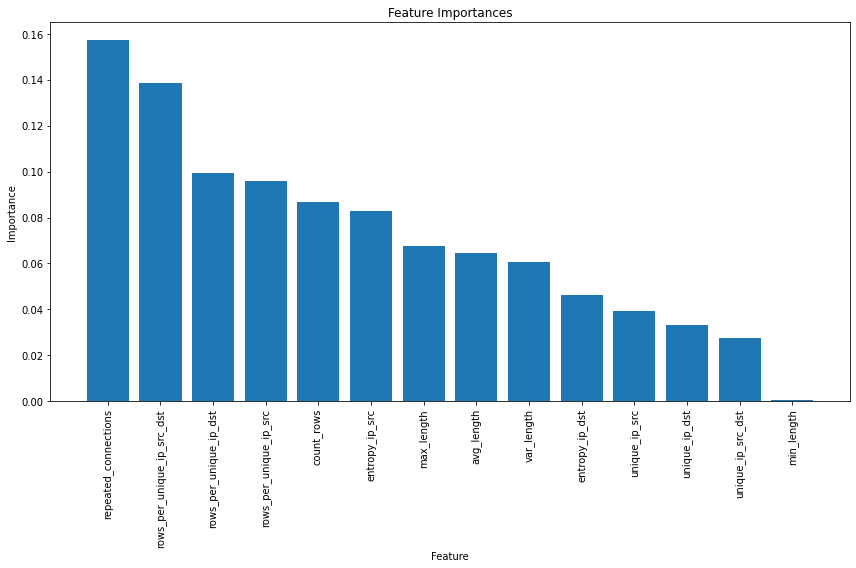

In [34]:
import matplotlib.pyplot as plt
feature_importances = rf_classifier.feature_importances_

# Getting feature names
feature_names = X_train.columns

# Sorting the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Creating a bar plot for feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()